In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  sklearn.svm import LinearSVC

In [48]:

class CoordinateDescentSVM:
    def __init__(self, C=1.0, max_iter=100, tol=1e-4, sigma=0.01, beta=0.5, block_size = 1):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.sigma = sigma
        self.beta = beta
        self.w = None
        self.block_size = block_size

    def _d_prime_i_0(self, X, y, i):
        margins = 1 - y * (X @ self.w)
        active = margins > 0
        bj = margins[active]
        xji = X[active, i]
        yj = y[active]
        gradient_sum = np.sum(yj * xji * bj)
        return self.w[i] - 2 * self.C * gradient_sum

    def _d_double_prime_i_0(self, X, y, i):
        margins = 1 - y * (X @ self.w)
        active = margins > 0
        xji = X[active, i]
        gradient_sum = np.sum(xji * xji)
        return 1 + 2 * self.C * gradient_sum

    def _newton_direction(self, X, y, i):
        numerator = self._d_prime_i_0(X, y, i)
        denominator = self._d_double_prime_i_0(X, y, i)
        return -numerator / denominator if denominator != 0 else 0.0

    def _d_i_z(self, X, y, i, z):
        ei = np.zeros(X.shape[1])
        ei[i] = 1
        w_new = self.w + z * ei
        margins = 1 - y * (X @ w_new)
        active = margins > 0
        bj = margins[active]
        loss_term = np.sum(bj ** 2)
        return 0.5 * np.dot(w_new, w_new) + self.C * loss_term

    def _compute_lambda(self, X, y, i, d):
        D0 = self._d_i_z(X, y, i, 0)
        z = d
        D_z = self._d_i_z(X, y, i, z)
        threshold = D_z - D0

        k = 1
        while threshold > -self.sigma * (z ** 2):
            z = d * (self.beta ** k)
            D_z = self._d_i_z(X, y, i, z)
            threshold = D_z - D0
            k += 1
        return self.beta ** (k - 1)

    def _coordinate_update(self, X, y, i):
        d = self._newton_direction(X, y, i)
        lam = self._compute_lambda(X, y, i, d)
        self.w[i] += lam * d
        
    def _block_indices(self, n_features):
        indices = np.arange(n_features)
        np.random.shuffle(indices)
        return [indices[i:i + self.block_size] for i in range(0, len(indices), self.block_size)]
        
    def _block_update(self, X, y, block):
        d = np.zeros_like(self.w)
        for i in block:
            d_i = self._newton_direction(X, y, i)
            d[i] = d_i
    
        # Wspólny krok lambda (backtracking dla całego bloku)
        lam = 1.0
        D0 = self._d_i_z_block(X, y, block, np.zeros_like(d))
        threshold = 1.0
        k = 0
    
        while threshold > -self.sigma * np.dot(d[block], d[block]):
            z = lam * d
            Dz = self._d_i_z_block(X, y, block, z)
            threshold = Dz - D0
            lam *= self.beta
            k += 1
            if k > 20:  # zabezpieczenie
                break
    
        self.w[block] += lam * d[block]

    def _d_i_z_block(self, X, y, block, z):
        w_new = self.w.copy()
        w_new[block] += z[block]
        margins = 1 - y * (X @ w_new)
        active = margins > 0
        bj = margins[active]
        loss_term = np.sum(bj ** 2)
        return 0.5 * np.dot(w_new, w_new) + self.C * loss_term

    
    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        i = 0
        if (self.block_size>1):
            for iteration in range(self.max_iter):
                print(i)
                i+=1
                w_old = self.w.copy()
                blocks = self._block_indices(X.shape[1])
                for block in blocks:
                    self._block_update(X, y, block)
        
                if np.linalg.norm(self.w - w_old) < self.tol:
                    print(f"Converged at iteration {iteration}")
                    break
        
            return self
        else:
            for iteration in range(self.max_iter):
                w_old = self.w.copy()
                for i in range(X.shape[1]):
                    self._coordinate_update(X, y, i)
    
                if np.linalg.norm(self.w - w_old) < self.tol:
                    print(f"Converged at iteration {iteration}")
                    break
    
            return self

    def predict(self, X):
        return np.sign(X @ self.w)


In [49]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Poprawione dane treningowe
X, y = make_classification(
    n_samples=2000,
    n_features=400,
    n_informative=400,
    n_redundant=0,
    n_repeated=0,
    random_state=42
)
y = 2 * y - 1  # zamiana etykiet na {-1, +1}
X = StandardScaler().fit_transform(X)


In [50]:
model = LinearSVC()
model_our  = CoordinateDescentSVM(block_size = 10)

In [51]:
model.fit(X, y)

LinearSVC()

In [52]:
model_our.fit(X, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


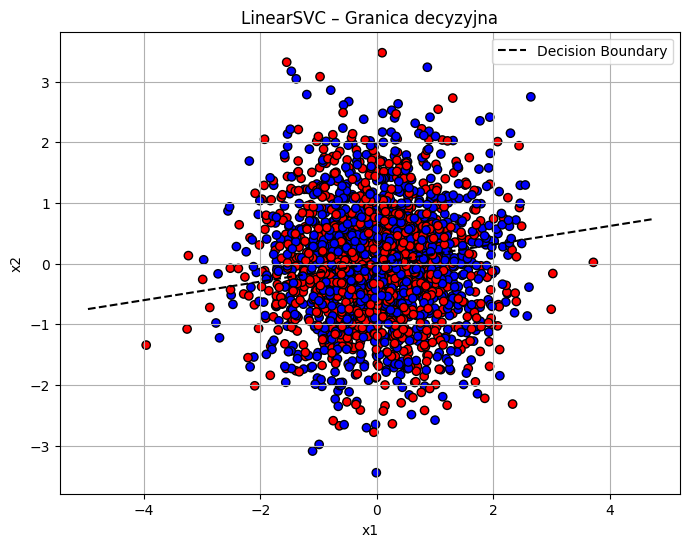

In [53]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:,0],X[:,1], c=y, cmap='bwr', edgecolors='k')

# Parametry granicy decyzyjnej: w1*x1 + w2*x2 + b = 0 → x2 = -(w1*x1 + b)/w2
w = model.coef_[0]
b = model.intercept_[0]

x_vals = np.linspace(X[:, 0].min() -1, X[:, 0].max() + 1, 200)
y_vals = -(w[0] * x_vals + b) 

plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('LinearSVC – Granica decyzyjna')
plt.legend()
plt.grid(True)
plt.show()

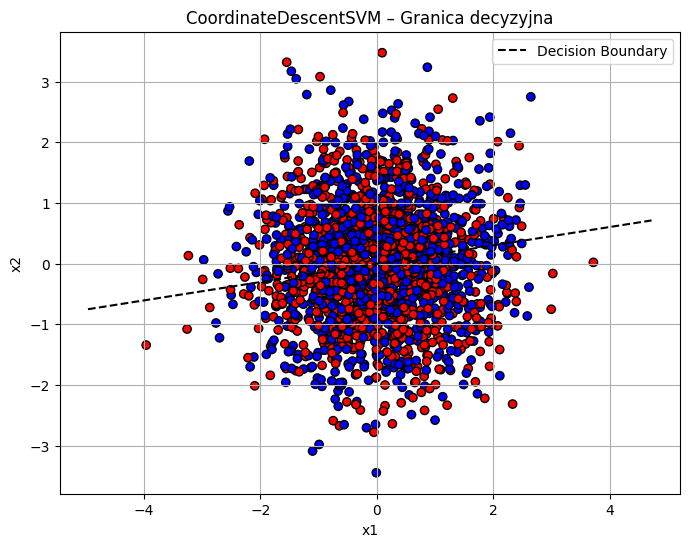

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:,0],X[:,1], c=y, cmap='bwr', edgecolors='k')

# Parametry granicy decyzyjnej: w1*x1 + w2*x2 + b = 0 → x2 = -(w1*x1 + b)/w2
w = model_our.w[:]

x_vals = np.linspace(X[:, 0].min() -1, X[:, 0].max() + 1, 200)
y_vals = -(w[0] * x_vals ) 

plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('CoordinateDescentSVM – Granica decyzyjna')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
 #algorithm_2:
Beta = 0.5
#1. Given wk,i. Choose β ∈ (0, 1) (e.g., β = 0.5).
#2. Calculate the Newton direction d  = −D′i(0)/D′′i(0)
#3. Compute λ = max{1, β, β2, . . .} such that z = λd satisfies (12).
#(12) Di(z) − Di(0) ≤ −σz2,
import numpy as np

def D_prime_i_0(wk, X, y, C, i):
    margins = 1 - y * (X @ wk)
    active = margins > 0
    bj = margins[active]              
    xji = X[active, i]
    yj = y[active]

    gradient_sum = np.sum(yj * xji * bj)
    return wk[i] - 2 * C * gradient_sum

def D_double_prime_i_0(wk, X, y, C, i):
    margins = 1 - y * (X @ wk)
    active = margins > 0
    xji = X[active, i]
    gradient_sum = np.sum(xji*xji)
    return 1 + 2 * C *gradient_sum
    
def Newton_direction(wk, X, y, C, i):
    return - D_prime_i_0(wk, X, y, C, i)/D_double_prime_i_0(wk, X, y, C, i)

def D_i_z(wk, X, y, C, i,z):
    ei = np.zeros(X.shape[1])
    ei[i] = 1
    w_new = wk + z * ei
    
    margins = 1 - y * (X @ w_new)
    active = margins > 0
    bj = margins[active]
    yactive = y[active]
    Xactive = X[active]
    gradient_sum = np.sum(bj ** 2)
    return (1/2) * np.dot(w_new,w_new) + C * gradient_sum

def compute_Lambda(wk, X, y, C, i, sigma, Beta):
    D0 = D_i_z(wk, X, y, C, i,0)
    d = Newton_direction(wk, X, y, C, i)
    step = 1 * d
    threshold = D_i_z(wk, X, y, C, i,step) - D0
    
    numerator = 1 
    while (threshold > - sigma * (step)**2):
        step = d * (Beta ** numerator)
        numerator +=1
        threshold = D_i_z(wk, X, y, C, i,step) - D0
    return  Beta ** (numerator - 1)

def coordinate_update(wk, X, y, C, i, sigma=0.01, Beta=0.5):
    d = Newton_direction(wk, X, y, C, i)
    lam = compute_Lambda(wk, X, y, C, i, sigma, Beta)
    wk[i] += lam * d
    return wk

def coordinate_descent(X, y, C=1.0, max_iter=100, tol=1e-4):
    wk = np.zeros(X.shape[1])

    for iteration in range(max_iter):
        wk_old = wk.copy()
        for i in range(X.shape[1]):
            wk = coordinate_update(wk, X, y, C, i)

        if np.linalg.norm(wk - wk_old) < tol:
            print(f"Converged at iteration {iteration}")
            break

    return wk


In [20]:
wk = coordinate_descent(X, y)

Converged at iteration 5
